In [1]:
from nilmtk import DataSet

# Load UK-DALE dataset from your path
dataset = DataSet('D:/lusip/ukdale.h5/ukdale.h5')

# Show the available buildings
print("Available buildings:", dataset.buildings)

# Select Building 1
elec = dataset.buildings[1].elec

# List all appliances in the building
print("Appliances in Building 1:")
print(elec.appliances)


Available buildings: OrderedDict({1: Building(instance=1, dataset='UK-DALE'), 2: Building(instance=2, dataset='UK-DALE'), 3: Building(instance=3, dataset='UK-DALE'), 4: Building(instance=4, dataset='UK-DALE'), 5: Building(instance=5, dataset='UK-DALE')})
Appliances in Building 1:
[Appliance(type='broadband router', instance=1), Appliance(type='charger', instance=1), Appliance(type='boiler', instance=1), Appliance(type='kettle', instance=1), Appliance(type='radio', instance=1), Appliance(type='baby monitor', instance=1), Appliance(type='food processor', instance=1), Appliance(type='immersion heater', instance=1), Appliance(type='washer dryer', instance=1), Appliance(type='kitchen aid', instance=1), Appliance(type='desktop computer', instance=1), Appliance(type='security alarm', instance=1), Appliance(type='dish washer', instance=1), Appliance(type='light', instance=3), Appliance(type='light', instance=6), Appliance(type='light', instance=12), Appliance(type='HTPC', instance=1), Applianc

c:\Users\tanmay\AppData\Local\Programs\Python\Python313\Lib\site-packages\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
c:\Users\tanmay\AppData\Local\Programs\Python\Python313\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))


<Axes: title={'center': 'Mains Power (Building 1)'}>

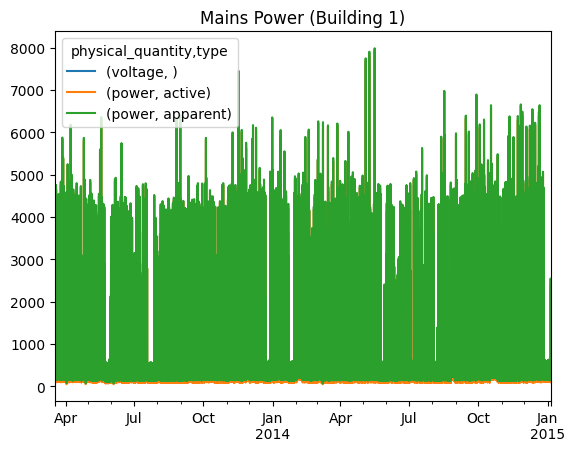

In [2]:
# Load aggregate mains power at 6-second intervals
mains_df = next(elec.mains().load(sample_period=6))

# Plot mains power
mains_df.plot(title='Mains Power (Building 1)')


c:\Users\tanmay\AppData\Local\Programs\Python\Python313\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))


<Axes: title={'center': 'Kettle Power (Building 1)'}>

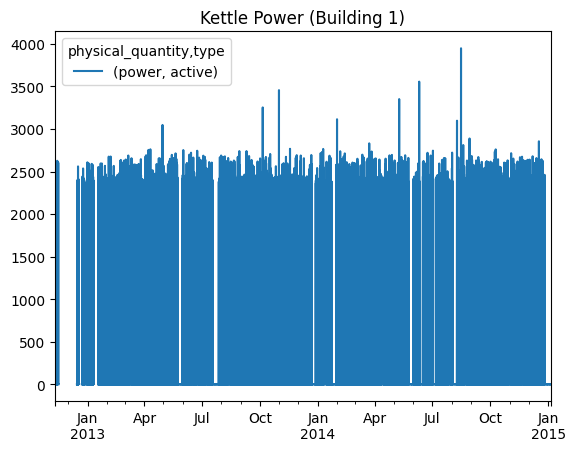

In [3]:
# Load kettle power at 6-second intervals
kettle_df = next(elec['kettle'].load(sample_period=6))

# Plot kettle power
kettle_df.plot(title='Kettle Power (Building 1)')


In [4]:
# Keep only active power for mains
mains_df = mains_df[('power', 'active')].to_frame()
mains_df.columns = ['mains']  # Rename for simplicity

# Keep only active power for kettle
kettle_df = kettle_df[('power', 'active')].to_frame()
kettle_df.columns = ['kettle']


In [5]:
# Align timestamps (inner join)
aligned_df = mains_df.join(kettle_df, how='inner')

# Drop NaN rows
aligned_df.dropna(inplace=True)

# Remove kettle power peaks > 3000W
aligned_df = aligned_df[aligned_df['kettle'] <= 3000]

# Check sample
print(aligned_df.head())


                                mains  kettle
2013-03-17 19:12:42+00:00  339.523987     1.0
2013-03-17 19:12:48+00:00  339.588348     1.0
2013-03-17 19:12:54+00:00  339.195007     1.0
2013-03-17 19:13:00+00:00  339.511688     1.0
2013-03-17 19:13:06+00:00  339.971649     1.0


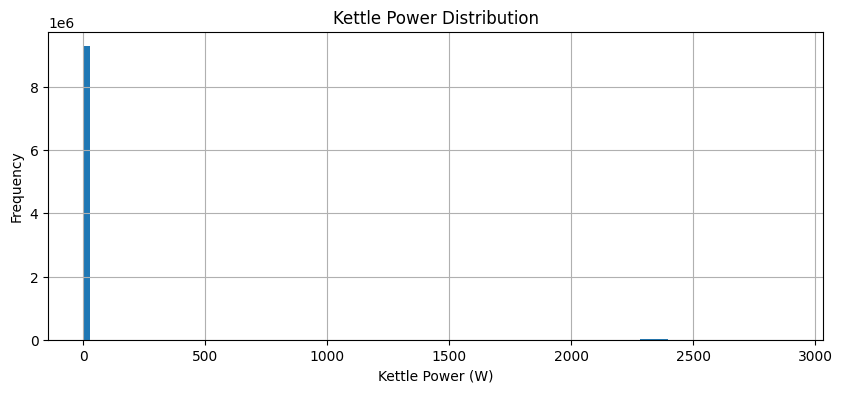

In [6]:
import matplotlib.pyplot as plt

# Histogram of kettle usage
aligned_df['kettle'].plot(kind='hist', bins=100, figsize=(10, 4), title='Kettle Power Distribution')
plt.xlabel('Kettle Power (W)')
plt.grid(True)
plt.show()


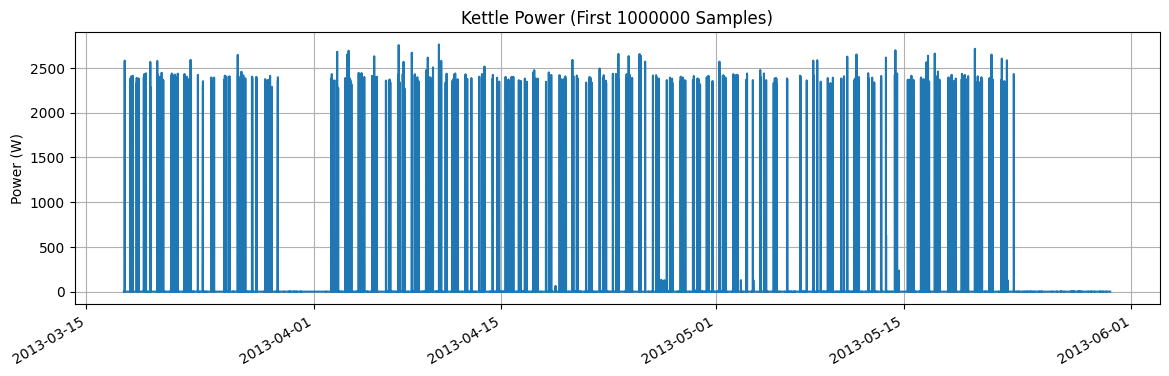

In [7]:
# Plot first 1000 time steps
aligned_df['kettle'][:1000000].plot(figsize=(14, 4), title="Kettle Power (First 1000000 Samples)")
plt.ylabel("Power (W)")
plt.grid(True)
plt.show()


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Create separate scalers
mains_scaler = MinMaxScaler()
kettle_scaler = MinMaxScaler()

# Normalize each column
aligned_df['mains'] = mains_scaler.fit_transform(aligned_df[['mains']])
aligned_df['kettle'] = kettle_scaler.fit_transform(aligned_df[['kettle']])

# Check result
print(aligned_df.head())


                              mains    kettle
2013-03-17 19:12:42+00:00  0.037168  0.000346
2013-03-17 19:12:48+00:00  0.037177  0.000346
2013-03-17 19:12:54+00:00  0.037127  0.000346
2013-03-17 19:13:00+00:00  0.037167  0.000346
2013-03-17 19:13:06+00:00  0.037225  0.000346


In [9]:
import numpy as np

def create_balanced_sequences(df, window_size=99, off_fraction=0.05):
    X, y = [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size]
        target = window['kettle'].values[-1]

        # Keep all ON events
        if target > 0.05:
            X.append(window['mains'].values)
            y.append(target)
        # Keep a fraction of OFF events
        elif np.random.rand() < off_fraction:
            X.append(window['mains'].values)
            y.append(target)

    return np.array(X), np.array(y)

X, y = create_balanced_sequences(aligned_df, window_size=99, off_fraction=0.05)
print("X shape:", X.shape)
print("y shape:", y.shape)



X shape: (523859, 99)
y shape: (523859,)


In [10]:
from sklearn.model_selection import train_test_split

# Use subset to keep training time reasonable
subset_size = 500_000
X_subset = X[:subset_size]
y_subset = y[:subset_size]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


X_train: (400000, 99)
X_test: (100000, 99)


In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Reshape for LSTM input: (samples, sequence_length, 1)
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoaders
BATCH_SIZE = 256
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE)


In [12]:
import torch.nn as nn

class LSTMTransformer(nn.Module):
    def __init__(self, input_size=1, hidden_size=72, num_heads=4, ff_dim=208, num_layers=3):
        super(LSTMTransformer, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.transformer(x)
        center = x[:, x.size(1) // 2, :]
        return self.fc(center).squeeze()


In [13]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("CUDA Available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0))
model = LSTMTransformer().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00011090132629828084)

EPOCHS = 15
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.6f}")


CUDA Available: True
Device: NVIDIA GeForce RTX 3050 Laptop GPU
Epoch [1/15], Loss: 0.025334
Epoch [2/15], Loss: 0.011849
Epoch [3/15], Loss: 0.008248
Epoch [4/15], Loss: 0.006680
Epoch [5/15], Loss: 0.005730
Epoch [6/15], Loss: 0.005049
Epoch [7/15], Loss: 0.004624
Epoch [8/15], Loss: 0.003564
Epoch [9/15], Loss: 0.003359
Epoch [10/15], Loss: 0.003193
Epoch [11/15], Loss: 0.003058
Epoch [12/15], Loss: 0.003021
Epoch [13/15], Loss: 0.002941
Epoch [14/15], Loss: 0.002928
Epoch [15/15], Loss: 0.002762


In [14]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Predict on test set
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        predictions.extend(preds)
        actuals.extend(yb.numpy())

# Inverse transform
preds_inv = kettle_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals_inv = kettle_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

# Apply filtering: only samples where actual and predicted ≤ 3000W and actual > 10W
mask = (actuals_inv <= 3000) & (preds_inv <= 3000) & (actuals_inv > 10)
filtered_preds = preds_inv[mask]
filtered_actuals = actuals_inv[mask]

# Compute MAE & MAPE
mae = mean_absolute_error(filtered_actuals, filtered_preds)
mape = np.mean(np.abs((filtered_actuals - filtered_preds) / (filtered_actuals + 1e-8))) * 100

print(f"\n✅ Final Filtered MAE (<=3000W): {mae:.2f} watts")
print(f"✅ Final Filtered MAPE (<=3000W, >10W): {mape:.2f}%")



✅ Final Filtered MAE (<=3000W): 125.04 watts
✅ Final Filtered MAPE (<=3000W, >10W): 10.25%


In [15]:
# ✅ Post-processing: Treat kettle as binary ON/OFF
# Threshold: if power > 0.1 × 3000 = 300W, it's ON
threshold = 0.1

# Convert predictions and actuals to binary ON/OFF
binary_preds = (preds_inv > threshold * 3000).astype(int)
binary_actuals = (actuals_inv > 10).astype(int)  # Treat actual >10W as ON

# Convert ON state to fixed 2400W, OFF to 0
preds_fixed = binary_preds * 2400
actuals_fixed = binary_actuals * 2400

# Calculate MAE and MAPE on binary-rescaled values
mae_fixed = mean_absolute_error(actuals_fixed, preds_fixed)
on_mask = actuals_fixed == 2400
mape_fixed = np.mean(
    np.abs((actuals_fixed[on_mask] - preds_fixed[on_mask]) / (actuals_fixed[on_mask] + 1e-8))
) * 100


print(f"\n✅ Post-Processed MAE (Binary): {mae_fixed:.2f} W")
print(f"✅ Post-Processed MAPE (Binary): {mape_fixed:.2f}%")



✅ Post-Processed MAE (Binary): 16.13 W
✅ Post-Processed MAPE (Binary): 1.87%


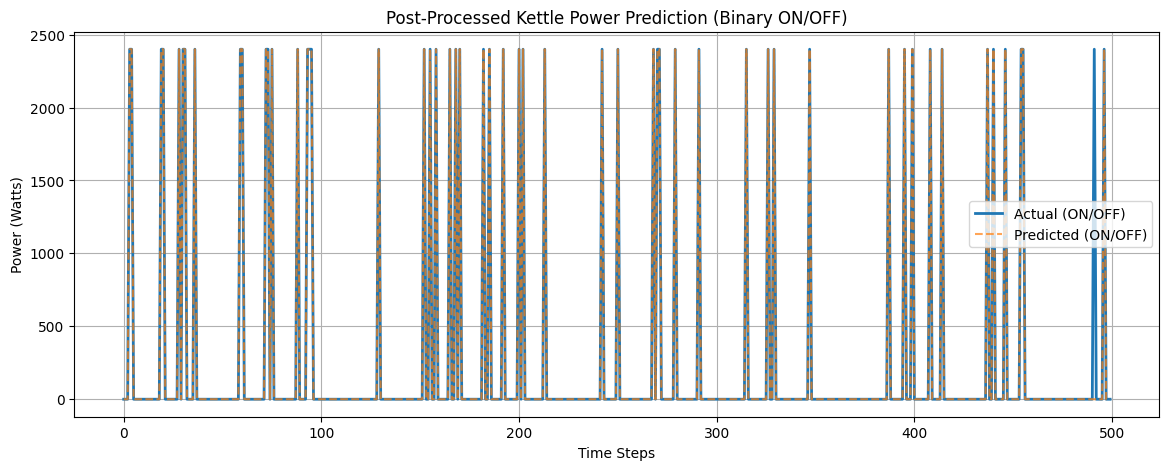

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(actuals_fixed[:500], label='Actual (ON/OFF)', linewidth=2)
plt.plot(preds_fixed[:500], label='Predicted (ON/OFF)', linestyle='--', alpha=0.7)
plt.title("Post-Processed Kettle Power Prediction (Binary ON/OFF)")
plt.xlabel("Time Steps")
plt.ylabel("Power (Watts)")
plt.legend()
plt.grid(True)
plt.show()
